# スパース符号化 (sparse coding)

### 画像データの読み込み
データは<http://www.rctn.org/bruno/sparsenet/>からダウンロードできる [^datasets]．`IMAGES_RAW.mat`は10枚の自然画像で，`IMAGES.mat`はそれを白色化したものである．`mat`ファイルの読み込みには[MAT.jl](https://github.com/JuliaIO/MAT.jl)を用いる．

[^datasets]: これはアメリカ北西部で撮影された自然画像であり，[van Hateren's Natural Image Dataset](http://bethgelab.org/datasets/vanhateren/)から取得されたものである．

In [1]:
# thresholding function of S(x)=|x|
function soft_thresholding_func(x, lmda)
    max(x - lmda, 0)#- max(-x - lmda, 0)
end

soft_thresholding_func (generic function with 1 method)

In [2]:
using MAT
using PyPlot

In [3]:
# datasets from http://www.rctn.org/bruno/sparsenet/
mat_images_raw = matopen("../_static/datasets/IMAGES_RAW.mat")
imgs = read(mat_images_raw, "IMAGESr")
#imgs_raw = read(mat_images_raw, "IMAGESr")

#mat_images = matopen("../_static/datasets/IMAGES.mat")
#imgs = read(mat_images, "IMAGES")

close(mat_images_raw)
close(mat_images)

LoadError: UndefVarError: mat_images not defined

In [4]:
using Base: @kwdef
using Parameters: @unpack # or using UnPack
using LinearAlgebra
using Random
using Statistics
using ProgressMeter

モデルを定義する．

In [5]:
@kwdef struct OFParameter{FT}
    lr_r::FT = 1e-2 # learning rate of r
    lr_Phi::FT = 1e-2 # learning rate of Phi
    lmda::FT = 5e-3 # regularization parameter
end

@kwdef mutable struct OlshausenField1996Model{FT}
    param::OFParameter = OFParameter{FT}()
    num_inputs::Int32
    num_units::Int32
    batch_size::Int32
    r::Array{FT} = zeros(batch_size, num_units) # activity of neurons
    Phi::Array{FT} = randn(num_inputs, num_units) .* sqrt(1/num_units)
end

パラメータを更新する関数を定義する．

In [6]:
function updateOF!(variable::OlshausenField1996Model, param::OFParameter, inputs::Array, training::Bool)
    @unpack num_inputs, num_units, batch_size, r, Phi = variable
    @unpack lr_r, lr_Phi, lmda = param

    # Updates                
    error = inputs .- r * Phi'
    r_ = r +lr_r .* error * Phi

    r[:, :] = soft_thresholding_func.(r_, lmda)

    if training 
        error = inputs - r * Phi'
        dPhi = error' * r
        Phi[:, :] += lr_Phi * dPhi
    end
    
    return error
end

updateOF! (generic function with 1 method)

In [7]:
function normalize_rows(A::Array)
    return A ./ sqrt.(sum(A.^2, dims=1) .+ 1e-8)
end

normalize_rows (generic function with 1 method)

In [8]:
function calculate_total_error(error, r, lmda)
    recon_error = mean(error.^2)
    sparsity_r = lmda*mean(abs.(r)) 
    return recon_error + sparsity_r
end

calculate_total_error (generic function with 1 method)

シミュレーションを実行する関数を定義する．外側の`for loop`では画像パッチの作成と`r`の初期化を行う．内側の`for loop`では`r`が収束するまで更新を行い，収束したときに重み行列`Phi`を更新する．

In [39]:
function run_simulation(imgs, num_iter, nt_max, batch_size, sz, num_units, eps)
    H, W, num_images = size(imgs)
    num_inputs = sz^2

    model = OlshausenField1996Model{Float32}(num_inputs=num_inputs, num_units=num_units, batch_size=batch_size)
    errorarr = zeros(num_iter) # Vector to save errors    
    
    # Run simulation
    @showprogress "Computing..." for iter in 1:num_iter
        # Get the coordinates of the upper left corner of clopping image randomly.
        beginx = rand(1:W-sz, batch_size)
        beginy = rand(1:H-sz, batch_size)

        inputs = zeros(batch_size, num_inputs)  # Input image patches

        # Get images randomly
        for i in 1:batch_size        
            idx = rand(1:num_images)
            img = imgs[:, :, idx]
            clop = img[beginy[i]:beginy[i]+sz-1, beginx[i]:beginx[i]+sz-1][:]
            inputs[i, :] = 0.4*(clop .- mean(clop))
        end

        model.r = zeros(batch_size, num_units) # Reset r states
        model.Phi = normalize_rows(model.Phi) # Normalize weights
        # Input image patches until latent variables are converged 
        r_tm1 = zeros(batch_size, num_units)  # set previous r (t minus 1)

        for t in 1:nt_max
            # Update r without update weights 
            error = updateOF!(model, model.param, inputs, false)

            dr = model.r - r_tm1 

            # Compute norm of r
            dr_norm = sqrt(sum(dr.^2)) / sqrt(sum(r_tm1.^2) + 1e-8)
            r_tm1 .= model.r # update r_tm1
            # Check convergence of r, then update weights
            if dr_norm < eps
                error = updateOF!(model, model.param, inputs, true)
                errorarr[iter] = calculate_total_error(error, model.r, model.param.lmda) # Append errors
                break
            end

            # If failure to convergence, break and print error
            if t >= nt_max-1
                print("Error at patch:", iter_, dr_norm)
                errorarr[iter] = calculate_total_error(error, model.r, model.param.lmda) # Append errors
                break
            end
        end

        # Print moving average error
        if iter % 100 == 0
            moving_average_error = mean(errorarr[iter-99:iter])
            println("iter: ", iter, "/", num_iter, ", Moving average error:", moving_average_error)
        end
    end
    return model, errorarr
end

run_simulation (generic function with 1 method)

In [33]:
maximum(imgs)
minimum(imgs)

-3.1948752300813794

`r_tm1 .= model.r`の部分は，要素ごとのコピーを実行している．`r_tm1 = copy(model.r)`でもよいが，新たなメモリ割り当てが生じるので避けている．`@. r_tm1 = model.r`としてもよい．

### シミュレーションの実行

In [40]:
# Simulation constants
num_iter = 500 # number of iterations
nt_max = 100 # Maximum number of simulation time
batch_size = 250 # Batch size

sz = 16 # image patch size
num_units = 100 # number of neurons (units)
eps = 1e-2 # small value which determines convergence

model, errorarr = run_simulation(imgs, num_iter, nt_max, batch_size, sz, num_units, eps);

Computing...100%|███████████████████████████████████████| Time: 0:01:30


iter: 100/500, Moving average error:0.03406588289253701
iter: 200/500, Moving average error:0.030329383367637033
iter: 300/500, Moving average error:0.029994149633620234
iter: 400/500, Moving average error:0.029536897772747372
iter: 500/500, Moving average error:0.02962341171929407


### 訓練中の損失の描画
訓練中の損失の変化を描画してみよう．損失が低下し，学習が進行したことが分かる．

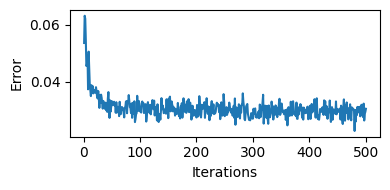

In [41]:
# Plot error
figure(figsize=(4, 2))
ylabel("Error")
xlabel("Iterations")
plot(1:num_iter, errorarr)
tight_layout()

### 重み行列 (受容野)の描画
学習後の重み行列 `Phi` ($\mathbf{\Phi}$)を可視化してみよう．

In [37]:
sqrt(sum(model.Phi[1, :] .^ 2))

0.7142812f0

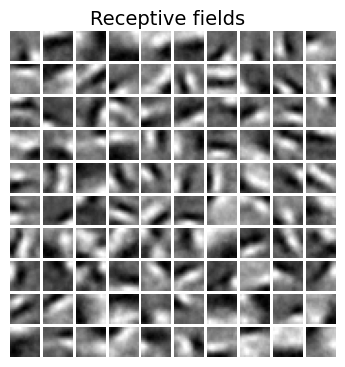

In [42]:
# Plot Receptive fields
figure(figsize=(4.2, 4))
subplots_adjust(hspace=0.1, wspace=0.1)
for i in 1:num_units
    subplot(10, 10, i)
    imshow(reshape(model.Phi[:, i], (sz, sz)), cmap="gray")
    axis("off")
end
suptitle("Receptive fields", fontsize=14)
subplots_adjust(top=0.925)

白色が**ON領域**(興奮)，黒色が**OFF領域**(抑制)を表す．Gaborフィルタ様の局所受容野が得られており，これは一次視覚野(V1)における単純型細胞(simple cells)の受容野に類似している．

### 画像の再構成
学習したモデルを用いて入力画像が再構成されるか確認しよう．

In [14]:
H, W, num_images = size(imgs)
num_inputs = sz^2

# Get the coordinates of the upper left corner of clopping image randomly.
beginx = rand(1:W-sz, batch_size)
beginy = rand(1:H-sz, batch_size)

inputs = zeros(batch_size, num_inputs)  # Input image patches

# Get images randomly
for i in 1:batch_size        
    idx = rand(1:num_images)
    img = imgs[:, :, idx]
    clop = img[beginy[i]:beginy[i]+sz-1, beginx[i]:beginx[i]+sz-1][:]
    inputs[i, :] = clop .- mean(clop)
end

model.r = zeros(batch_size, num_units) # Reset r states

# Input image patches until latent variables are converged 
r_tm1 = zeros(batch_size, num_units)  # set previous r (t minus 1)

for t in 1:nt_max
    # Update r without update weights 
    error = updateOF!(model, model.param, inputs, false)

    dr = model.r - r_tm1 

    # Compute norm of r
    dr_norm = sqrt(sum(dr.^2)) / sqrt(sum(r_tm1.^2) + 1e-8)
    r_tm1 .= model.r # update r_tm1

    # Check convergence of r, then update weights
    if dr_norm < eps
        break
    end
end

神経活動 $\mathbf{r}$がスパースになっているか確認しよう．

In [15]:
println(model.r[1, :])

Float32[0.0, 1.6546926, 0.0, 0.0, 0.0, 0.7991353, 0.0, 0.0, 0.0, 0.0, 1.0946983, 0.0, 0.0, 0.0, 0.0, 1.7372775, 0.0, 0.0, 0.44332784, 0.29225764, 0.0, 0.0, 0.0, 0.0, 0.4647945, 0.087881885, 0.0, 0.0, 0.0, 0.23949103, 0.0, 0.0, 0.022375442, 0.0, 0.6295185, 0.28205404, 0.0, 0.7460163, 0.0, 0.04723145, 0.0, 1.9076418, 0.0, 0.7642422, 0.0, 0.0, 0.0, 0.0, 0.89906406, 0.0, 0.36826682, 0.0, 0.0, 0.0, 0.6104044, 0.480703, 0.0, 0.0, 0.0, 0.119518906, 0.0, 1.3074596, 1.5075607, 1.7092451, 0.0, 1.3743078, 1.1343809, 0.0, 0.2271655, 0.0, 0.0, 0.0, 0.8375756, 0.0, 0.0, 0.21150406, 0.0, 0.0, 0.09190289, 0.99638927, 2.0109456, 0.0, 0.0, 0.26003212, 0.0, 1.0828798, 1.0192811, 0.0, 0.21368073, 0.0, 0.0, 0.0, 0.1901327, 1.2620959, 0.4563957, 0.0, 0.22615178, 0.2619544, 0.0, 0.0]


要素がほとんど0のスパースなベクトルになっていることがわかる．次に画像を再構成する．

In [16]:
reconst = model.r * model.Phi'
println(size(reconst))

(250, 256)


再構成した結果を描画する．

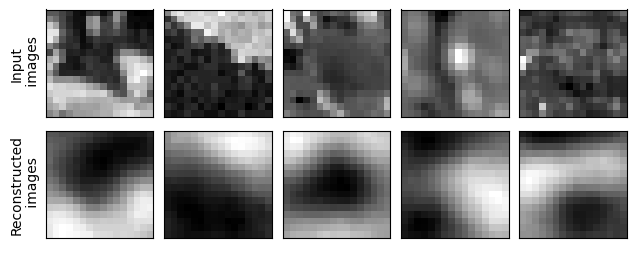

In [17]:
figure(figsize=(7.5, 3))
subplots_adjust(hspace=0.1, wspace=0.1)
num_show = 5
for i in 1:num_show
    subplot(2, num_show, i)
    imshow(reshape(inputs[i, :], (sz, sz)), cmap="gray")
    xticks([]); yticks([]); 
    if i == 1
        ylabel("Input\n images")
    end

    subplot(2, num_show, num_show+i)
    imshow(reshape(reconst[i, :], (sz, sz)), cmap="gray")
    xticks([]); yticks([]); 
    if i == 1
        ylabel("Reconstructed\n images")
    end
end

上段が入力画像，下段が再構成された画像である．差異はあるものの，概ね再構成されていることがわかる．

```{admonition} 論文以外の参考資料
- <http://www.scholarpedia.org/article/Sparse_coding>
- Bruno Olshausen: “Sparse coding in brains and machines”([Stanford talks](https://talks.stanford.edu/bruno-olshausen-sparse-coding-in-brains-and-machines/)), [Slide](http://www.rctn.org/bruno/public/Simons-sparse-coding.pdf)
- <https://redwood.berkeley.edu/wp-content/uploads/2018/08/sparse-coding-ICA.pdf>
- <https://redwood.berkeley.edu/wp-content/uploads/2018/08/sparse-coding-LCA.pdf>
- <https://redwood.berkeley.edu/wp-content/uploads/2018/08/Dylan-lca_overcompleteness_09-27-2018.pdf>
```